# Simple Policy Gradient

- https://spinningup.openai.com/en/latest/spinningup/rl_intro3.html
- https://spinningup.openai.com/en/latest/algorithms/vpg.html

## Imports

In [1]:
import numpy as np
import gymnasium as gym

import torch
import torch.nn as nn
import torch.distributions as dist
import torch.optim as optim

import matplotlib.pyplot as plt
from IPython import display

### Utilities

In [2]:
def plot_loss(losses, rets):
    display.clear_output(True)

    plt.figure(figsize=(12, 4))

    ax1 = plt.subplot(1, 2, 1)
    ax1.plot(losses)
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')

    ax2 = plt.subplot(1, 2, 2)
    ax2.plot(rets)
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Return')

    plt.show()


def render(env):
    plt.imshow(env.render())
    plt.axis('off')
    plt.show()
    display.clear_output(wait=True)

## Models

In [3]:
class Actor(nn.Module):
    def __init__(self, env, hidden_size=32):
        super().__init__()
        obs_dim = env.observation_space.shape[0]
        acts_dim = env.action_space.n
        self.mlp = nn.Sequential(
            nn.Linear(obs_dim, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, acts_dim),
        )

    def forward(self, obs):
        logits = self.mlp(obs)
        return dist.Categorical(logits=logits)

    def get_action(self, obs):
        return self.forward(obs).sample().item()

    def compute_loss(self, obs, act, adv):
        logp = self.forward(obs).log_prob(act)
        return -(logp * adv).mean()

## Train

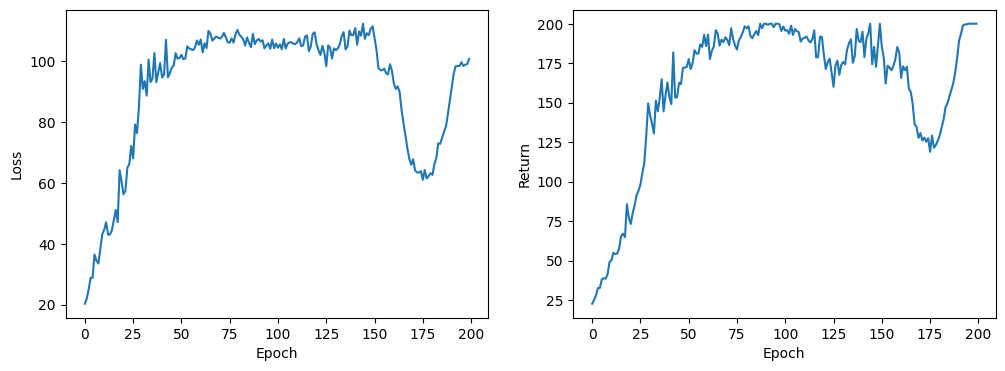

In [4]:
def train():
    batch_obs = []
    batch_acts = []
    batch_rets = []
    rets = []

    obs, _ = env.reset()
    rewards = []

    # Collect a batch of data
    actor.eval()
    while True:
        batch_obs.append(obs)

        act = actor.get_action(torch.as_tensor(obs, dtype=torch.float32))
        obs, reward, terminated, truncated, _ = env.step(act)
        done = terminated or truncated

        batch_acts.append(act)
        rewards.append(reward)

        if done:
            # Calculate the return
            ret = sum(rewards)
            rets.append(ret)
            batch_rets += [ret] * len(rewards)

            if len(batch_obs) > batch_size:
                break

            obs, _ = env.reset()
            rewards = []

    # Update the policy
    actor.train()
    optimizer.zero_grad()
    batch_loss = actor.compute_loss(
        obs=torch.as_tensor(batch_obs, dtype=torch.float32),
        act=torch.as_tensor(batch_acts, dtype=torch.int32),
        adv=torch.as_tensor(batch_rets, dtype=torch.float32)
    )
    batch_loss.backward()
    optimizer.step()

    return batch_loss.item(), np.mean(rets)


# Hyperparameters
env_name = 'CartPole-v0'
learning_rate = 1e-2
batch_size = 5000
epochs = 200

# Initialize the environment and the models
env = gym.make(env_name, render_mode='rgb_array')
actor = Actor(env)
optimizer = optim.Adam(actor.parameters(), lr=learning_rate)

# Train the policy
losses = []
rets = []
for epoch in range(epochs):
    loss, ret = train()
    losses.append(loss)
    rets.append(ret)
    plot_loss(losses, rets)

## Evaluate

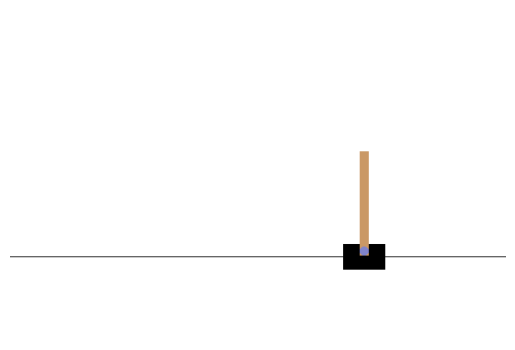

In [5]:
obs, _ = env.reset()
done = False
while not done:
    render(env)
    act = actor.get_action(torch.as_tensor(obs, dtype=torch.float32))
    obs, _, terminated, truncated, _ = env.step(act)
    done = terminated or truncated